In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.nn.init as init

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading Dataset

In [ ]:
def formatLabel(label):
    return label[:5]

def extractVowelAndConsonant(label):
    vowel, consonant = label.split('_')
    return vowel[1], consonant[1]

In [ ]:
class TamilVowelConsonantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png')
        ]

        self.labels = [formatLabel(os.path.splitext(fname)[0]) for fname in os.listdir(root_dir)]

        # Create mappings for vowels and consonants
        vowels = sorted(set({label.split('_')[0][1] for label in self.labels}))
        consonants = sorted(set({label.split('_')[1][1] for label in self.labels}))

        self.vowel_to_idx = {vowel: idx for idx, vowel in enumerate(vowels)}
        self.consonant_to_idx = {consonant: idx for idx, consonant in enumerate(consonants)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]

        # Load the image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)


        vowel, consonant = extractVowelAndConsonant(self.labels[idx])
        vowel_label = torch.tensor(self.vowel_to_idx[vowel], dtype=torch.long)
        consonant_label = torch.tensor(self.consonant_to_idx[consonant], dtype=torch.long)

        return image, vowel_label, consonant_label

In [ ]:
train_root_dir = '/kaggle/input/padhai-tamil-vow-cons-classification/train/train'

# Define any transformations you'd like (e.g., normalization, resizing, augmentation)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create Dataset
dataset = TamilVowelConsonantDataset(root_dir=train_root_dir, transform=transform_train)

# Access a sample
sample_image, sample_vowel_label, sample_consonant_label = dataset[0]
print("Sample Image Shape:", sample_image.shape)
print(f"Label: {sample_vowel_label}, Label Type: {type(sample_vowel_label)}, Label Value: {sample_vowel_label.item()}")
print(f"Label: {sample_consonant_label}, Label Type: {type(sample_consonant_label)}, Label Value: {sample_consonant_label.item()}")

Sample Image Shape: torch.Size([3, 224, 224])
Label: 4, Label Type: <class 'torch.Tensor'>, Label Value: 4
Label: 9, Label Type: <class 'torch.Tensor'>, Label Value: 9


In [ ]:
# Define batch size and number of workers (for DataLoader parallelism)
batch_size = 16
num_workers = 4  # Set this based on your machine's available cores

train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders with optimizations for speed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [ ]:
images, vowel_labels, consonant_labels = next(iter(train_loader))

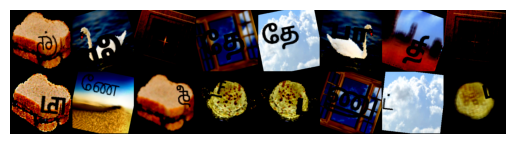

tensor([0, 8, 5, 8, 8, 2, 3, 6, 1, 8, 4, 3, 1, 5, 0, 5])
tensor([4, 2, 2, 7, 7, 9, 7, 5, 2, 6, 7, 8, 9, 6, 5, 7])


In [ ]:
imshow(torchvision.utils.make_grid(images))
print(vowel_labels)
print(consonant_labels)

# Training CNN

In [ ]:
class VowelConsonantClassifier(nn.Module):
    def __init__(self, backbone='vgg16_bn', num_vowels=10, num_consonants=10):
        super(VowelConsonantClassifier, self).__init__()

        # Backbone network
        if backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove the default FC layer
        elif backbone == 'vgg16_bn':
            self.backbone = models.vgg16_bn(pretrained=True)
            in_features = self.backbone.classifier[6].in_features
            self.backbone.classifier[6] = nn.Identity()
        else:
            raise ValueError("Unsupported backbone")

        # Separate heads for vowels and consonants
        self.vowel_head = nn.Sequential(
            # nn.Linear(25088, 4096),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(4096, 4096),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(4096, num_vowels)
        )

        self.consonant_head = nn.Sequential(
            # nn.Linear(25088, 4096),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(4096, 4096),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(4096, num_consonants)
        )

    def forward(self, x):
        # Extract shared features
        features = self.backbone(x)

        # Separate outputs for vowels and consonants
        vowel_logits = self.vowel_head(features)
        consonant_logits = self.consonant_head(features)

        return vowel_logits, consonant_logits


In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, vowel_labels, consonant_labels = data
            inputs, vowel_labels, consonant_labels = inputs.to(device), vowel_labels.to(device), consonant_labels.to(device)
            vowel_outputs, consonant_outputs = model(inputs)
            _, pred_vowels = torch.max(vowel_outputs.data, 1)
            _, pred_consonants = torch.max(consonant_outputs.data, 1)
            total += vowel_labels.size(0)
            correct += ((pred_vowels == vowel_labels) & (pred_consonants == consonant_labels)).sum().item()
    return 100 * correct / total

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at {filename}")

In [ ]:
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))  # For loading on CPU
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: epoch {epoch}, loss {loss}")
    return model, optimizer, epoch, loss

In [ ]:
model = VowelConsonantClassifier()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


In [ ]:
for param in model.backbone.features.parameters():
    param.required_grad=False

In [ ]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # Automatically distribute across GPUs

model = model.to(device)

Using 2 GPUs!


In [ ]:
best_loss = float('inf')

In [ ]:
learning_rate = 0.05
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epochs=8

In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_id, data in enumerate(train_loader):
        inputs, vowel_labels, consonant_labels = data
        inputs, vowel_labels, consonant_labels = inputs.to(device), vowel_labels.to(device), consonant_labels.to(device)

        vowel_outputs, consonant_outputs = model(inputs)
        loss_vowel = loss_fn(vowel_outputs, vowel_labels)
        loss_consonant = loss_fn(consonant_outputs, consonant_labels)
        loss = loss_vowel + loss_consonant

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred_vowels = torch.max(vowel_outputs, 1)
        _, pred_consonants = torch.max(consonant_outputs, 1)
        correct_train += ((pred_vowels == vowel_labels) & (pred_consonants == consonant_labels)).sum().item()
        total_train += vowel_labels.size(0)

        if batch_id % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(epoch + 1, batch_id * len(inputs), len(train_loader.dataset),
                                                                           100. * batch_id / len(train_loader), loss.data.item()))

        del inputs, vowel_labels, consonant_labels, vowel_outputs, consonant_outputs
        torch.cuda.empty_cache()

    train_loss_history.append(train_loss / len(train_loader))
    train_acc_history.append(correct_train / total_train)

    # Validation Phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, vowel_labels, consonant_labels in val_loader:
            inputs, vowel_labels, consonant_labels = inputs.to(device), vowel_labels.to(device), consonant_labels.to(device)
            vowel_outputs, consonant_outputs = model(inputs)
            loss_vowel = loss_fn(vowel_outputs, vowel_labels)
            loss_consonant = loss_fn(consonant_outputs, consonant_labels)
            loss = loss_vowel + loss_consonant

            val_loss += loss.item()
            _, pred_vowels = torch.max(vowel_outputs, 1)
            _, pred_consonants = torch.max(consonant_outputs, 1)
            correct_val += ((pred_vowels == vowel_labels) & (pred_consonants == consonant_labels)).sum().item()
            total_val += vowel_labels.size(0)

            del inputs, vowel_labels, consonant_labels, vowel_outputs, consonant_outputs
            torch.cuda.empty_cache()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(correct_val / total_val)

        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint(model, optimizer, epoch+1, best_loss, filename="best_checkpoint.pth")
            print('Best Loss %0.2f' % best_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_history[-1]:.4f}, Val Loss: {val_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]*100:.2f}%, Val Acc: {val_acc_history[-1]*100:.2f}%")


Train Epoch: 1 [0/8000 (0%)]	Loss: 4.8655
Train Epoch: 1 [1600/8000 (20%)]	Loss: 2.8756
Train Epoch: 1 [3200/8000 (40%)]	Loss: 1.7080
Train Epoch: 1 [4800/8000 (60%)]	Loss: 1.5224
Train Epoch: 1 [6400/8000 (80%)]	Loss: 1.5813
Checkpoint saved at best_checkpoint.pth
Best Loss 0.98
Epoch 1/8, Train Loss: 2.0887, Val Loss: 0.9767, Train Acc: 46.59%, Val Acc: 74.05%
Train Epoch: 2 [0/8000 (0%)]	Loss: 0.9776
Train Epoch: 2 [1600/8000 (20%)]	Loss: 1.1912
Train Epoch: 2 [3200/8000 (40%)]	Loss: 0.2042
Train Epoch: 2 [4800/8000 (60%)]	Loss: 0.3336
Train Epoch: 2 [6400/8000 (80%)]	Loss: 0.5746
Checkpoint saved at best_checkpoint.pth
Best Loss 0.64
Epoch 2/8, Train Loss: 0.8076, Val Loss: 0.6370, Train Acc: 78.03%, Val Acc: 83.50%
Train Epoch: 3 [0/8000 (0%)]	Loss: 0.3752
Train Epoch: 3 [1600/8000 (20%)]	Loss: 1.1147
Train Epoch: 3 [3200/8000 (40%)]	Loss: 0.4342
Train Epoch: 3 [4800/8000 (60%)]	Loss: 0.7363
Train Epoch: 3 [6400/8000 (80%)]	Loss: 0.3143
Checkpoint saved at best_checkpoint.pth
Best

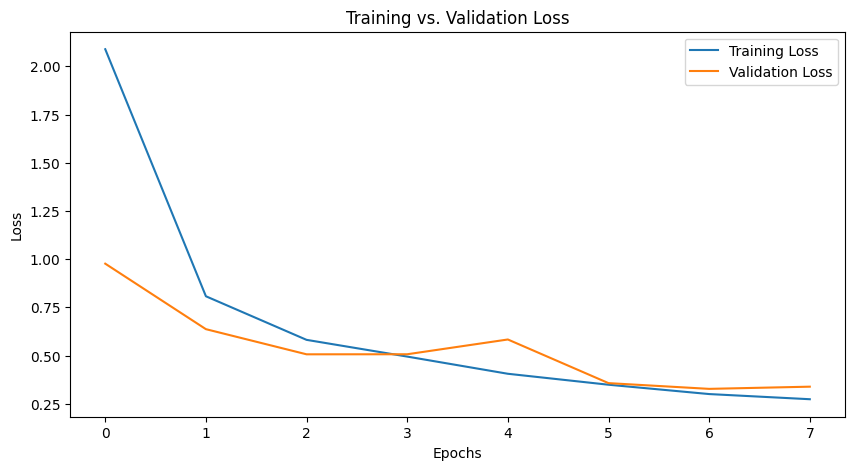

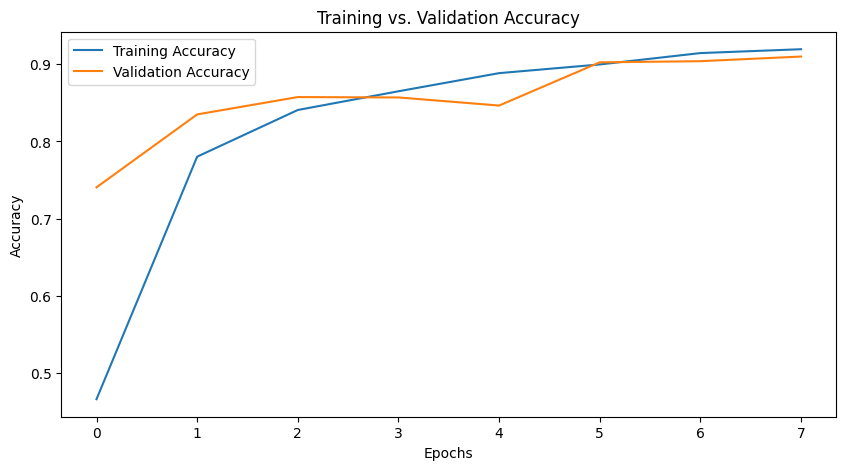

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# # Resuming Training
checkpoint_path = "best_checkpoint.pth"
best_model, best_optimizer, epoch, best_loss = load_checkpoint(checkpoint_path, model, optimizer)
# # print('Test Acc (cur model): %0.2f, Test Acc (best model): %0.2f' % (evaluation(test_loader, model), evaluation(test_loader, best_model)))

<ipython-input-13-07e22bbb37de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device('cpu'))  # For loading on CPU


Checkpoint loaded: epoch 7, loss 0.3273758637830615


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model.eval()  # Set the model to evaluation mode

DataParallel(
  (module): VowelConsonantClassifier(
    (backbone): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(

In [ ]:
# Define preprocessing steps (match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size
    transforms.ToTensor(),       # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open and convert to RGB
    return transform(image)  # Apply transforms

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, folder, transform):
        self.image_paths = [os.path.join(folder, img) for img in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.transform(image_path)
        file_name = os.path.basename(image_path)
        return image, file_name

# Create dataset and dataloader
folder_path = '/kaggle/input/padhai-tamil-vow-cons-classification/test/test/'  # Path to your folder
dataset = InferenceDataset(folder_path, preprocess_image)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
results = []

with torch.no_grad():  # Disable gradient computation
    for inputs, image_paths in dataloader:
        inputs = inputs.to(device)  # Move inputs to the correct device
        outputs = model(inputs)    # Forward pass

        # Assuming two outputs: vowel and consonant predictions
        vowel_outputs, consonant_outputs = outputs
        _, pred_vowels = torch.max(vowel_outputs, 1)
        _, pred_consonants = torch.max(consonant_outputs, 1)

        # Collect results
        for i, path in enumerate(image_paths):
            results.append({
                "ImageId": path,
                "Class": f"V{pred_vowels[i].item()}_C{pred_consonants[i].item()}"
            })


In [ ]:

df = pd.DataFrame(results)
df.to_csv('submisision.csv', index=False)

In [ ]:
print(df.head(10))

    ImageId  Class
0  9273.png  V9_C2
1  9292.png  V9_C2
2  4353.png  V4_C3
3  7968.png  V7_C9
4  6490.png  V6_C4
5  5511.png  V5_C5
6  6262.png  V6_C2
7  2664.png  V2_C6
8  8419.png  V8_C4
9  9703.png  V9_C7
